In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation(degrees=180), #
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/classification'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

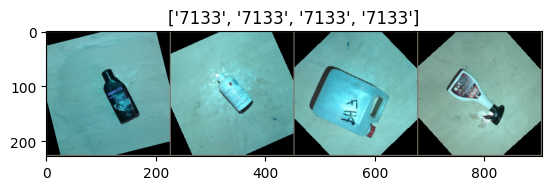

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# ResNet18

In [5]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/marc/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/marc/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3512 Acc: 0.4866
val Loss: 2.5547 Acc: 0.2673

Epoch 1/24
----------
train Loss: 0.9633 Acc: 0.6506
val Loss: 1.9444 Acc: 0.4432

Epoch 2/24
----------
train Loss: 0.7517 Acc: 0.7379
val Loss: 2.6440 Acc: 0.3869

Epoch 3/24
----------
train Loss: 0.6299 Acc: 0.7867
val Loss: 3.4173 Acc: 0.3447

Epoch 4/24
----------
train Loss: 0.4879 Acc: 0.8246
val Loss: 3.4113 Acc: 0.4221

Epoch 5/24
----------
train Loss: 0.4420 Acc: 0.8522
val Loss: 2.4395 Acc: 0.4352

Epoch 6/24
----------
train Loss: 0.3507 Acc: 0.8846
val Loss: 3.1014 Acc: 0.4533

Epoch 7/24
----------
train Loss: 0.2205 Acc: 0.9309
val Loss: 2.2926 Acc: 0.4663

Epoch 8/24
----------
train Loss: 0.1682 Acc: 0.9486
val Loss: 2.1295 Acc: 0.4543

Epoch 9/24
----------
train Loss: 0.1470 Acc: 0.9512
val Loss: 2.2262 Acc: 0.4543

Epoch 10/24
----------
train Loss: 0.1385 Acc: 0.9623
val Loss: 2.0696 Acc: 0.4814

Epoch 11/24
----------
train Loss: 0.1278 Acc: 0.9615
val Loss: 2.1586 Acc: 0.4734

Ep

In [7]:
torch.save(model_ft, "../data/models/resnet18.pt")

In [8]:
model_ft = torch.load("../data/models/resnet18.pt")
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
class_names

['7042', '7051', '7055', '7133', 'others']

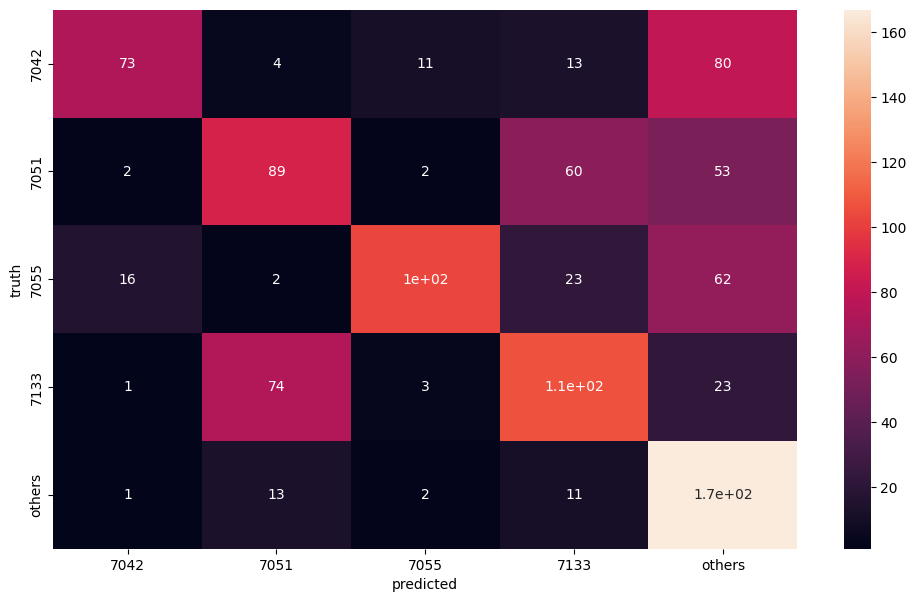

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                output = model_ft(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

# constant for classes
classes = class_names

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("truth");

In [11]:
print("Accuracy on validation data")
sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

Accuracy on validation data


0.5417085427135678

# ResNet18 as fixed feature extractor (only changes weights of final layer)

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/home/marc/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/marc/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5115 Acc: 0.3907
val Loss: 1.9429 Acc: 0.3628

Epoch 1/24
----------
train Loss: 1.4292 Acc: 0.4641
val Loss: 1.8449 Acc: 0.3407

Epoch 2/24
----------
train Loss: 1.3504 Acc: 0.4833
val Loss: 2.0441 Acc: 0.3739

Epoch 3/24
----------
train Loss: 1.3541 Acc: 0.4934
val Loss: 2.3234 Acc: 0.3116

Epoch 4/24
----------
train Loss: 1.3619 Acc: 0.4965
val Loss: 2.0720 Acc: 0.3397

Epoch 5/24
----------
train Loss: 1.3211 Acc: 0.5061
val Loss: 1.8959 Acc: 0.3638

Epoch 6/24
----------
train Loss: 1.3124 Acc: 0.5159
val Loss: 1.8686 Acc: 0.3578

Epoch 7/24
----------
train Loss: 1.1292 Acc: 0.5605
val Loss: 1.9033 Acc: 0.3508

Epoch 8/24
----------
train Loss: 1.0988 Acc: 0.5746
val Loss: 1.8312 Acc: 0.3658

Epoch 9/24
----------
train Loss: 1.0961 Acc: 0.5731
val Loss: 1.9202 Acc: 0.3457

Epoch 10/24
----------
train Loss: 1.1117 Acc: 0.5653
val Loss: 1.8929 Acc: 0.3598

Epoch 11/24
----------
train Loss: 1.1084 Acc: 0.5714
val Loss: 1.7699 Acc: 0.3668

Ep

In [14]:
torch.save(model_conv, "../data/models/resnet18_feat.pt")

In [15]:
model_conv = torch.load("../data/models/resnet18_feat.pt")
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

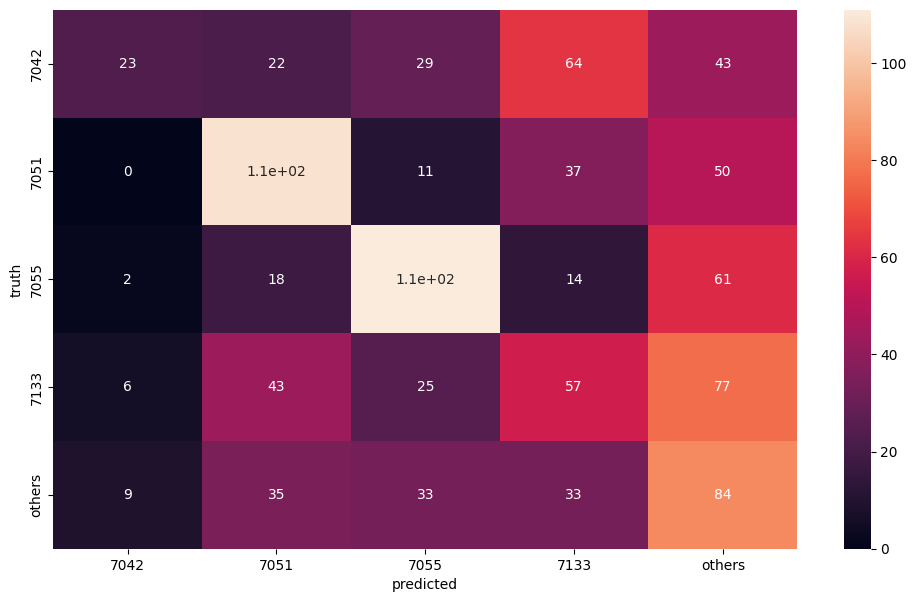

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                output = model_conv(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

# constant for classes
classes = class_names

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("truth");

In [17]:
print("Accuracy on validation data")
sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

Accuracy on validation data


0.3849246231155779

# ResNet50

In [5]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/marc/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/marc/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.2309 Acc: 0.5326
val Loss: 3.8693 Acc: 0.3588

Epoch 1/24
----------
train Loss: 0.7594 Acc: 0.7338
val Loss: 2.5580 Acc: 0.4281

Epoch 2/24
----------
train Loss: 0.4978 Acc: 0.8211
val Loss: 2.6155 Acc: 0.4281

Epoch 3/24
----------
train Loss: 0.4139 Acc: 0.8623
val Loss: 2.2344 Acc: 0.4352

Epoch 4/24
----------
train Loss: 0.3196 Acc: 0.8897
val Loss: 2.3714 Acc: 0.4573

Epoch 5/24
----------
train Loss: 0.2566 Acc: 0.9193
val Loss: 3.3976 Acc: 0.4392

Epoch 6/24
----------
train Loss: 0.2133 Acc: 0.9360
val Loss: 3.0414 Acc: 0.4985

Epoch 7/24
----------
train Loss: 0.1231 Acc: 0.9633
val Loss: 2.9808 Acc: 0.5729

Epoch 8/24
----------
train Loss: 0.0879 Acc: 0.9732
val Loss: 2.7721 Acc: 0.5729

Epoch 9/24
----------
train Loss: 0.0982 Acc: 0.9737
val Loss: 2.7114 Acc: 0.5598

Epoch 10/24
----------
train Loss: 0.0812 Acc: 0.9762
val Loss: 3.0788 Acc: 0.5568

Epoch 11/24
----------
train Loss: 0.0919 Acc: 0.9767
val Loss: 3.0914 Acc: 0.6000

Ep

In [7]:
torch.save(model_ft, "../data/models/resnet50.pt")

In [8]:
model_ft = torch.load("../data/models/resnet50.pt")
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

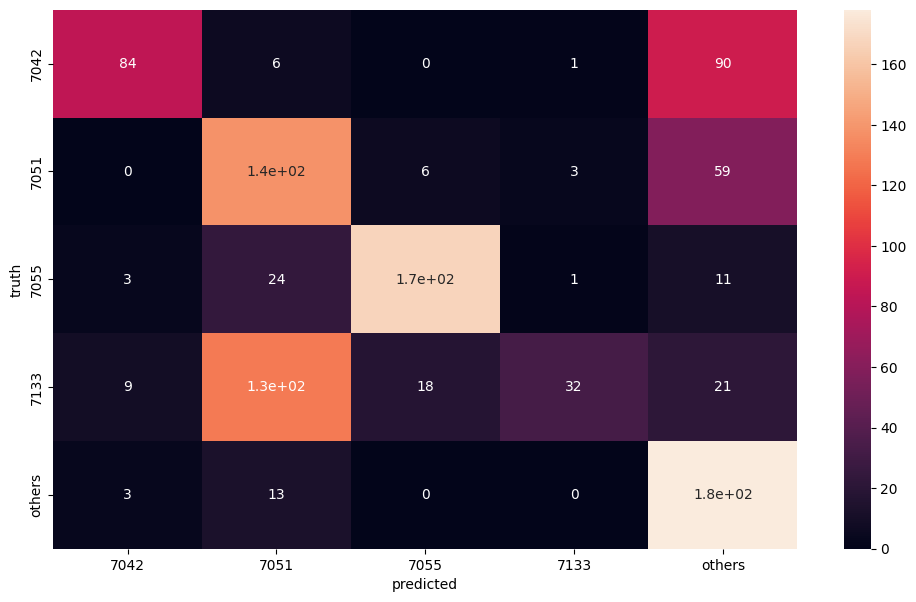

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
with torch.no_grad():
        for inputs, labels in dataloaders["val"]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                output = model_ft(inputs) # Feed Network

                output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                y_pred.extend(output) # Save Prediction

                labels = labels.data.cpu().numpy()
                y_true.extend(labels) # Save Truth

# constant for classes
classes = class_names

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("truth");

In [10]:
print("Accuracy on validation data")
sum(np.array(y_true) == np.array(y_pred)) / len(y_true)

Accuracy on validation data


0.6020100502512563